# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [19]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact

In [20]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

px.set_mapbox_access_token(mapbox_token)

# Import Data

In [39]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path, index_col="Neighborhood")

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [65]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    mean_houses = sfo_data.groupby('year')['housing_units'].mean()
    
    fig_housing_units = plt.figure()
    
    ax = mean_houses.plot(kind='bar', title="Housing Units in San Francisco from 2010 to 2016")
    ax.set_ylabel("Housing Units")
    ax.set_xlabel("Year")
    
    ax.set_ylim(mean_houses.min() - mean_houses.std(), mean_houses.max() + mean_houses.std())

    return fig_housing_units


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    rent_df = sfo_data.groupby('year')['sale_price_sqr_foot', 'gross_rent'].mean()

    fig_gross_rent = plt.figure()

    ax = rent_df['gross_rent'].plot(kind='line', title="Average Gross Rent in San Francisco")
    ax.set_ylabel("Gross Rent")
    ax.set_xlabel("Year")

    return fig_gross_rent


def average_sales_price():
    """Average Sales Price Per Year."""
    
    rent_df = sfo_data.groupby('year')['sale_price_sqr_foot', 'gross_rent'].mean()
    
    fig_sale_price = plt.figure()
    
    ax = rent_df['sale_price_sqr_foot'].plot(kind='line', title="Average Sale Price per Square Foot in San Francisco")
    ax.set_ylabel("Avg. Sale Price")
    ax.set_xlabel("Year")
    
    return fig_sale_price


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    hv_mean_sfo_df = sfo_data.groupby(['year', 'neighborhood']).mean()
    hv_mean_sfo_df = hv_mean_sfo_df.reset_index()

    plot_sfo_mean = hv_mean_sfo_df.hvplot.line(label='San Francisco price per square foot', y='sale_price_sqr_foot', x='year', groupby='neighborhood')

    return plot_sfo_mean
    


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    hv_exp_sfo_df = sfo_data.groupby('neighborhood').mean().sort_values(['sale_price_sqr_foot'],ascending=False)
    hv_exp_sfo_top10 = hv_exp_sfo_df.iloc[0:10]
    
    plot_sfo_exp = hv_exp_sfo_top10.hvplot.bar(label='San Francisco most expensive neighborhoods', y='sale_price_sqr_foot', x='neighborhood')
    plot_sfo_exp.opts(xrotation=45)
    
    return plot_sfo_exp

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    hv_exp_sfo_df = sfo_data.groupby('neighborhood').mean().sort_values(['sale_price_sqr_foot'],ascending=False)
    hv_exp_sfo_top10 = hv_exp_sfo_df.iloc[0:10]
    
    parr_top_10 = hv_exp_sfo_top10.reset_index()
    result = px.parallel_coordinates(parr_top_10, color='sale_price_sqr_foot')
    
    return result


def parallel_categories():
    """Parallel Categories Plot."""
    
    hv_exp_sfo_df = sfo_data.groupby('neighborhood').mean().sort_values(['sale_price_sqr_foot'],ascending=False)
    hv_exp_sfo_top10 = hv_exp_sfo_df.iloc[0:10]
    
    parr_top_10 = hv_exp_sfo_top10.reset_index()
    
    result = px.parallel_categories(
        parr_top_10,
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="sale_price_sqr_foot",
    )

    return result


def neighborhood_map():
    """Neighborhood Map"""
    
    mean_df = sfo_data.groupby('neighborhood').mean()

    mapbox_df = pd.concat([df_neighborhood_locations, mean_df], axis=1, join='inner')
    mapbox_df = mapbox_df.reset_index()
    mapbox_df.rename({"index" : "neighborhood"}, axis=1, inplace=True)
    
    map_1 = px.scatter_mapbox(mapbox_df, lat="Lat", lon="Lon", color="neighborhood")
    
    return map_1



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

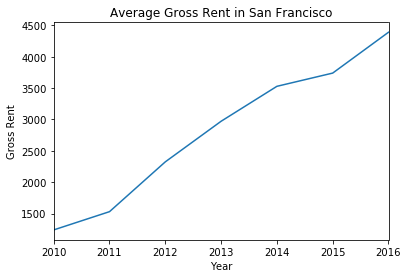

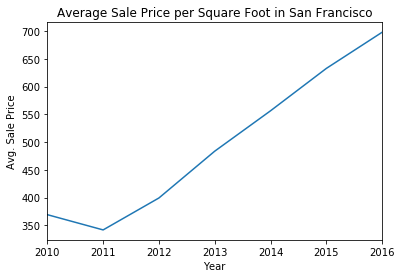

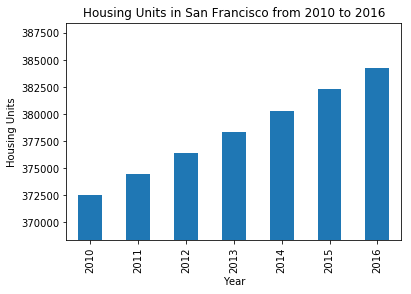

In [71]:
row = pn.Row(average_gross_rent(), average_sales_price())

avg_column = pn.Column(
    "## Gross Rent and Sale Price", housing_units_per_year, row
)

interact_column = pn.Column(
    "## Interact with neighborhood prices", average_price_by_neighborhood()
)

top10_column = pn.Column(
    "## Top 10 most expensive areas", top_most_expensive_neighborhoods()
)

par_column = pn.Column(
    "## Parallel graph", parallel_coordinates(), parallel_categories()
)

mapbox_column = pn.Column(
    "## Mapbox API", neighborhood_map()
)

panel = pn.Tabs(
    ("Summary averages", avg_column), 
    ("Neighborhoods", interact_column),
    ("Parallel", par_column),
    ("Mapbox", mapbox_column)
)

## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Column()
            [1] Row
                [0] Matplotlib(Figure, name='interactive05333')
        [2] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
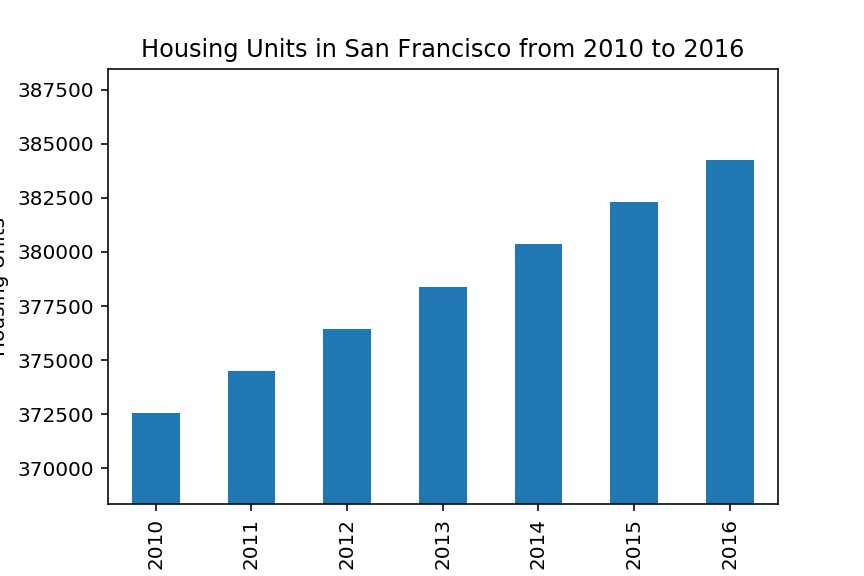
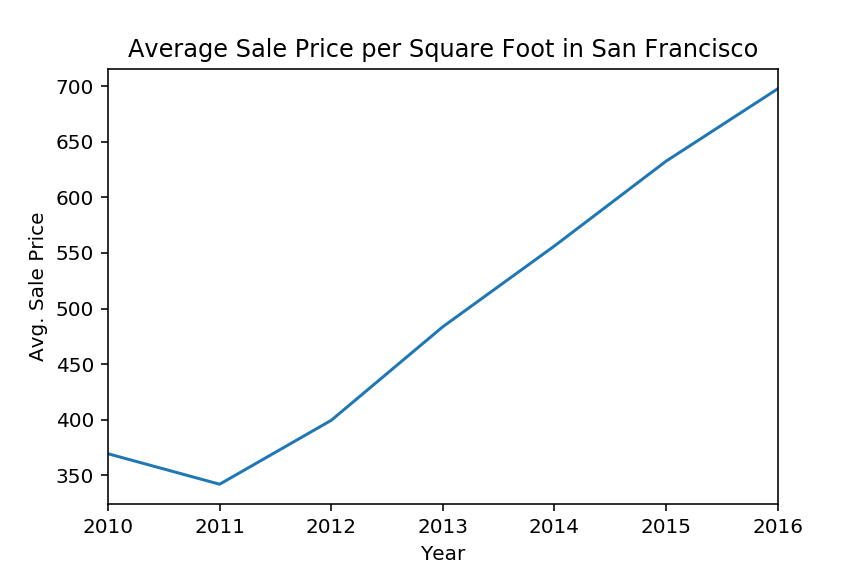
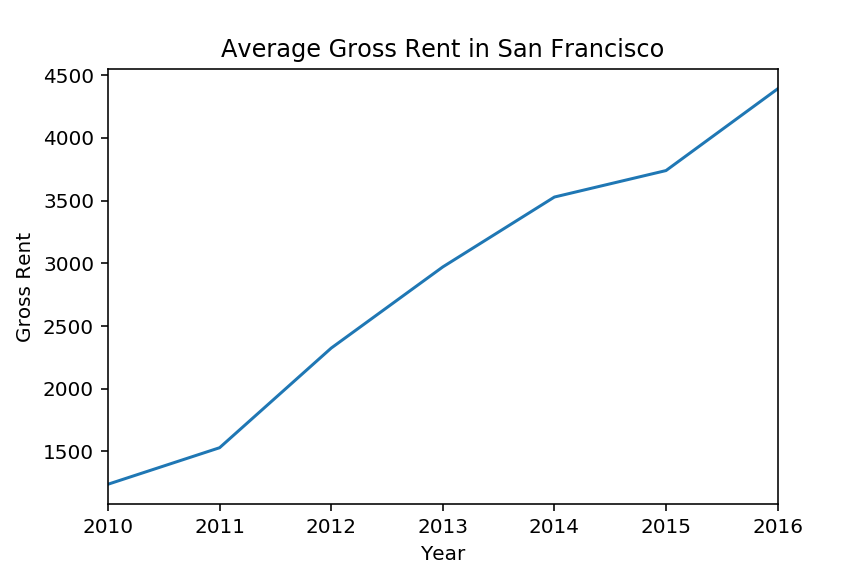

In [72]:
panel.servable()